In [42]:
# Standard library imports
import argparse
import gzip
import math
import re
import sys
import urllib.request
import io
import random
from copy import deepcopy

# Third-party library imports
import numpy as np
import pandas as pd
import gensim
import gensim.downloader as api
from gensim import corpora, matutils
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import wordnet
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# load pre-trained Word2Vec model
model = api.load('word2vec-google-news-300')

In [3]:
isNumber = re.compile(r'\d+.*')

def norm_word(word):
  """
  - input: word
  - return: a normalized version of it
  Normalization process: includes checking if the word is a number or a punctuation mark and replacing it with special tokens
  """
  if isNumber.search(word.lower()):
    return '---num---'
  # check if the word consists only of non-alphanumeric characters by removing all non-alphanumeric characters from the word 
  # and checking if the result is an empty string
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
  # if input word not a number nor a punctuation mark, return a lowercase version of input word
    return word.lower()
  

  
''' Read all the word vectors and normalize them '''
def read_word_vecs(filename):
  """
  - input: name of the file containing the word vectors
  """
  wordVectors = {}
  with open(filename, 'r', encoding='utf-8') as fileObject:
    for line in fileObject:
      line = line.strip().lower()
      # The first word is assumed to be the word itself, and the remaining words are assumed to be the components of the word vector
      word = line.split()[0]
      # initialize a numpy array of zeros with the same length as the word vector
      wordVectors[word] = np.zeros(len(line.split())-1, dtype=float)
      for index, vecVal in enumerate(line.split()[1:]):
        # assign the values in the numpy array to the corresponding components of the word vector
        wordVectors[word][index] = float(vecVal)
      ''' normalize weight vector '''
      # divide each element by the square root of the sum of the squares of all the elements in the array
      # plus a small constant (1e-6) to avoid division by zero
      wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)
  
  # standard error indicating that the vectors have been read from the file 
  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

  ''' Write word vectors to file '''
def print_word_vecs(wordVectors, outFileName):
  """
  - input: a dictionary wordVectors where keys are words and values are their corresponding word vectors
           file name outFileName
  """
  sys.stderr.write('\nWriting down the vectors in '+outFileName+'\n')
  outFile = open(outFileName, 'w', encoding= 'utf-8')  
  for word, values in wordVectors.items():
    outFile.write(word+' ')
    for val in wordVectors[word]:
      # write the word vectors to the ouptut file in the format:
      # word1 val1 val2 val3 ...
      # word2 val1 val2 val3 ...
      # ...
      outFile.write('%.4f' %(val)+' ')
    outFile.write('\n')      
  outFile.close()

''' Read the PPDB word relations as a dictionary '''
def read_lexicon(filename):
    lexicon = {}
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            words = line.lower().strip().split()
            lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]

In [4]:
# Getting the same format for the toy corpus as for the provided word embeddings
def convert_matrix_to_dict(wordVecMat, wordList):
    wordVecs = {}

    for i, word in enumerate(wordList):
        wordVecs[word] = wordVecMat[i]

    return wordVecs

def convert_dict_to_matrix(wordVecs):
    # words = list(wordVecs.keys())
    wordVecMat = np.array(list(wordVecs.values()))

    # Reshape the matrix if it is one-dimensional
    if wordVecMat.ndim == 1:
        wordVecMat = wordVecMat.reshape(1, -1)

    return wordVecMat

def vectorize_list(corpus):
    corpus_vecs = [model[word] for word in corpus]

    return corpus_vecs

In [5]:
toy_corpus = ["cat", "kitten", "dog", "donkey", "caramel", "cheese", "chocolate", "cacao", "right", "left"]

In [6]:
toy_corpus_vecs = vectorize_list(toy_corpus)
toy_corpus_vecs

[array([ 0.0123291 ,  0.20410156, -0.28515625,  0.21679688,  0.11816406,
         0.08300781,  0.04980469, -0.00952148,  0.22070312, -0.12597656,
         0.08056641, -0.5859375 , -0.00445557, -0.296875  , -0.01312256,
        -0.08349609,  0.05053711,  0.15136719, -0.44921875, -0.0135498 ,
         0.21484375, -0.14746094,  0.22460938, -0.125     , -0.09716797,
         0.24902344, -0.2890625 ,  0.36523438,  0.41210938, -0.0859375 ,
        -0.07861328, -0.19726562, -0.09082031, -0.14160156, -0.10253906,
         0.13085938, -0.00346375,  0.07226562,  0.04418945,  0.34570312,
         0.07470703, -0.11230469,  0.06738281,  0.11230469,  0.01977539,
        -0.12353516,  0.20996094, -0.07226562, -0.02783203,  0.05541992,
        -0.33398438,  0.08544922,  0.34375   ,  0.13964844,  0.04931641,
        -0.13476562,  0.16308594, -0.37304688,  0.39648438,  0.10693359,
         0.22167969,  0.21289062, -0.08984375,  0.20703125,  0.08935547,
        -0.08251953,  0.05957031,  0.10205078, -0.1

In [7]:
def calculate_cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_product = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    similarity = dot_product / norm_product
    return similarity

def generate_cosine_similarity_matrix(vectors):
    num_vectors = len(vectors)
    similarity_matrix = np.zeros((num_vectors, num_vectors))

    for i in range(num_vectors):
        for j in range(num_vectors):
            similarity = calculate_cosine_similarity(vectors[i], vectors[j])
            similarity_matrix[i, j] = similarity
    return similarity_matrix

def print_vec_similarities(corpus, vectorized_corpus):
    for i, vec1 in enumerate(vectorized_corpus):
        word1 = corpus[i]
        print(f'Similarities with "{word1}":')
        for j, vec2 in enumerate(vectorized_corpus):
            if i == j:
                continue
            similarity = calculate_cosine_similarity(vec1, vec2)
            print(f'  - "{corpus[j]}": {similarity:.4f}')
        print()

In [8]:
similarity_matrix = generate_cosine_similarity_matrix(toy_corpus_vecs)
print_vec_similarities(toy_corpus, similarity_matrix)

Similarities with "cat":
  - "kitten": 0.9688
  - "dog": 0.9724
  - "donkey": 0.7901
  - "caramel": 0.4268
  - "cheese": 0.3910
  - "chocolate": 0.5103
  - "cacao": 0.3105
  - "right": 0.2302
  - "left": 0.2539

Similarities with "kitten":
  - "cat": 0.9688
  - "dog": 0.9466
  - "donkey": 0.7895
  - "caramel": 0.4282
  - "cheese": 0.3506
  - "chocolate": 0.4904
  - "cacao": 0.2887
  - "right": 0.1814
  - "left": 0.2117

Similarities with "dog":
  - "cat": 0.9724
  - "kitten": 0.9466
  - "donkey": 0.8274
  - "caramel": 0.4426
  - "cheese": 0.4316
  - "chocolate": 0.5462
  - "cacao": 0.3257
  - "right": 0.2435
  - "left": 0.2427

Similarities with "donkey":
  - "cat": 0.7901
  - "kitten": 0.7895
  - "dog": 0.8274
  - "caramel": 0.4150
  - "cheese": 0.4585
  - "chocolate": 0.5234
  - "cacao": 0.3917
  - "right": 0.2643
  - "left": 0.2802

Similarities with "caramel":
  - "cat": 0.4268
  - "kitten": 0.4282
  - "dog": 0.4426
  - "donkey": 0.4150
  - "cheese": 0.8493
  - "chocolate": 0.9353


In [9]:
toy_wordVecs = convert_matrix_to_dict(toy_corpus_vecs, toy_corpus)

In [10]:
toy_wordVecs

{'cat': array([ 0.0123291 ,  0.20410156, -0.28515625,  0.21679688,  0.11816406,
         0.08300781,  0.04980469, -0.00952148,  0.22070312, -0.12597656,
         0.08056641, -0.5859375 , -0.00445557, -0.296875  , -0.01312256,
        -0.08349609,  0.05053711,  0.15136719, -0.44921875, -0.0135498 ,
         0.21484375, -0.14746094,  0.22460938, -0.125     , -0.09716797,
         0.24902344, -0.2890625 ,  0.36523438,  0.41210938, -0.0859375 ,
        -0.07861328, -0.19726562, -0.09082031, -0.14160156, -0.10253906,
         0.13085938, -0.00346375,  0.07226562,  0.04418945,  0.34570312,
         0.07470703, -0.11230469,  0.06738281,  0.11230469,  0.01977539,
        -0.12353516,  0.20996094, -0.07226562, -0.02783203,  0.05541992,
        -0.33398438,  0.08544922,  0.34375   ,  0.13964844,  0.04931641,
        -0.13476562,  0.16308594, -0.37304688,  0.39648438,  0.10693359,
         0.22167969,  0.21289062, -0.08984375,  0.20703125,  0.08935547,
        -0.08251953,  0.05957031,  0.1020507

In [11]:
type(similarity_matrix[0])

numpy.ndarray

In [12]:
def get_wordnet_lexicon(target_words, relation_types):
    lexicon = {}

    for word in target_words:
        related_words = []
        word_synsets = wordnet.synsets(word)
        
        # Skip word if no synsets found
        if not word_synsets:
            continue

        for syn in word_synsets:
            for lemma in syn.lemmas():
                if lemma.name() != word:
                    if "synonyms" in relation_types:
                        related_words.append(lemma.name())
            if "antonyms" in relation_types:
                if syn.lemmas()[0].antonyms():
                    related_words.append(syn.lemmas()[0].antonyms()[0].name())
            if "hyponyms" in relation_types:
                for hypo in syn.hyponyms():
                    for lemma in hypo.lemmas():
                        related_words.append(lemma.name())
            if "hypernyms" in relation_types:
                for hyper in syn.hypernyms():
                    for lemma in hyper.lemmas():
                        related_words.append(lemma.name())
            if "meronyms" in relation_types:
                for part in syn.part_meronyms():
                    for lemma in part.lemmas():
                        related_words.append(lemma.name())
            if "holonyms" in relation_types:
                for whole in syn.part_holonyms():
                    for lemma in whole.lemmas():
                        related_words.append(lemma.name())
            if "homonyms" in relation_types:
                for lemma in syn.lemmas():
                    if lemma.name() != word:
                        homonyms = wordnet.lemmas(lemma.name())
                        for homonym in homonyms:
                            related_words.append(homonym.name())
        lexicon[word] = related_words
    return lexicon

In [13]:
def convert_embeddings_to_matrix(wordVecs):
    wordVecMat = np.array(list(wordVecs.values()))
    return wordVecMat

wordVecMat = convert_embeddings_to_matrix(toy_wordVecs)

In [14]:
toy_wordVecs

{'cat': array([ 0.0123291 ,  0.20410156, -0.28515625,  0.21679688,  0.11816406,
         0.08300781,  0.04980469, -0.00952148,  0.22070312, -0.12597656,
         0.08056641, -0.5859375 , -0.00445557, -0.296875  , -0.01312256,
        -0.08349609,  0.05053711,  0.15136719, -0.44921875, -0.0135498 ,
         0.21484375, -0.14746094,  0.22460938, -0.125     , -0.09716797,
         0.24902344, -0.2890625 ,  0.36523438,  0.41210938, -0.0859375 ,
        -0.07861328, -0.19726562, -0.09082031, -0.14160156, -0.10253906,
         0.13085938, -0.00346375,  0.07226562,  0.04418945,  0.34570312,
         0.07470703, -0.11230469,  0.06738281,  0.11230469,  0.01977539,
        -0.12353516,  0.20996094, -0.07226562, -0.02783203,  0.05541992,
        -0.33398438,  0.08544922,  0.34375   ,  0.13964844,  0.04931641,
        -0.13476562,  0.16308594, -0.37304688,  0.39648438,  0.10693359,
         0.22167969,  0.21289062, -0.08984375,  0.20703125,  0.08935547,
        -0.08251953,  0.05957031,  0.1020507

In [47]:
def get_embeddings_words(wordVecs):
    wordList = list(wordVecs.keys()) # TODO: or set?
    return wordList

wordList = get_embeddings_words(toy_wordVecs)

In [16]:
def create_neighbors_embedding_matrix(wordList, relation_type):
    # Retrieve synonyms for each word
    neighbors_dict = get_wordnet_lexicon(wordList, relation_type)
    
    # Compute average embedding
    average_embeddings = []
    for word in wordList:
        neighbors = neighbors_dict.get(word, [])
        embeddings = [
            model.get_vector(neighbor)
            for neighbor in neighbors
            if model.has_index_for(neighbor)
        ]
        if len(embeddings) > 0:
            average_embedding = np.sum(embeddings, axis=0) / len(embeddings)
        else:
            # Handle the case where a word has no embeddings for its synonyms
            average_embedding = np.zeros(model.vector_size)  # Use a zero vector
        average_embeddings.append(average_embedding)
    
    # Create the word embedding matrix
    neighbors_embedding_matrix = np.vstack(average_embeddings)

    return neighbors_embedding_matrix

   
    
neighbors_matrix = create_neighbors_embedding_matrix(wordList, "synonyms")

# récupérer la liste des syn dans wordnet
# vectorise chaque syn
# BOW des synonymes (sum) pour n'avoir qu'un embedding 
# BOW_syn_cat
# BOW_syn_dog= neighbors_matrix, shape (10, embedding_size) donc same size as wordVecs_mat

In [17]:
print(type(neighbors_matrix))  # <class 'numpy.ndarray'>
print(neighbors_matrix.shape)  # (m, n)
print(neighbors_matrix.ndim)   # 2

<class 'numpy.ndarray'>
(10, 300)
2


In [18]:
print(type(wordVecMat))  # <class 'numpy.ndarray'>
print(wordVecMat.shape)  # (m, n)
print(wordVecMat.ndim)   # 2

<class 'numpy.ndarray'>
(10, 300)
2


In [19]:
difference = toy_corpus_vecs[0] - neighbors_matrix[0]
print(difference)

[ 0.00676925  0.17245371 -0.32560504 -0.02995695  0.24918167  0.06591797
  0.07754347  0.02062197  0.12026186 -0.24899179  0.11663705 -0.43598995
 -0.0165247  -0.43618888  0.05141873 -0.2046328   0.09973597  0.0461245
 -0.4420053   0.08787028  0.26338252 -0.1518453   0.11536521 -0.14642108
 -0.04931188  0.32405486 -0.15808557  0.31547716  0.40427201 -0.007934
 -0.00195312 -0.20903128 -0.03433369 -0.0849519   0.01340795  0.15198545
 -0.07754234  0.04350902  0.00148463  0.24564164  0.00093107  0.03174506
 -0.14347048  0.13828702  0.08990253 -0.03038646  0.37447442 -0.05503337
  0.00611821  0.00164738 -0.15880896  0.13665545  0.34953252  0.14862174
 -0.0103189  -0.14141733  0.15832859 -0.30018898  0.35803392  0.18776052
  0.28351056  0.18667716 -0.01274052  0.19207764  0.04131345  0.04772498
  0.20808016  0.02882668 -0.10890771 -0.12867793  0.40634721 -0.03548855
 -0.15468343 -0.01318077 -0.11528298  0.38514766  0.11844098 -0.08239746
 -0.02005401 -0.06692618  0.08503554 -0.00346544  0.19

In [38]:
lexicon = get_wordnet_lexicon(wordList, "synonyms")

In [32]:
def retrofitting_wordVecs(wordVecMat, neighbors_mean_matrix, alpha, beta, nb_iter):
    # Create a deep copy of wordVecMat 
    newWordVecMat = np.copy(wordVecMat, order='K')
    updates = []
    
    for _ in range(nb_iter):
        # Calculate the number of neighbors for each word
        numNeighbors = np.sum(neighbors_mean_matrix != 0, axis=1)
        
        # Update the word embeddings using retrofitting formula
        newWordVecMat = (alpha * newWordVecMat + beta * neighbors_mean_matrix) / (alpha + beta)

        # Calculate the updates
        update = newWordVecMat - wordVecMat
        updates.append(update)

        # Update the wordVecMat for the next iteration
        wordVecMat = newWordVecMat

        # Stoping criterion
        if np.linalg.norm(updates) < 1e-2:
            break

    # Convert the matrix back to a dictionary of word vectors
    # retrofitted_wordVecs = dict(zip(wordList, wordVecMat))

    return newWordVecMat, updates

In [51]:
import itertools

def generate_graph_from_synonyms(synonyms_dict):
    graph = {}
    
    # Create a set of all unique words in the dictionary
    words = set(synonyms_dict.keys()).union(*synonyms_dict.values())
    
    # Initialize an empty adjacency dictionary for each word
    for word in words:
        graph[word] = set()
    
    # Iterate through the synonyms dictionary
    for word, synonyms in synonyms_dict.items():
        # Add synonyms to the adjacency set for the word
        graph[word].update(synonyms)
        
        # Add the word as a synonym to each synonym's adjacency set
        for synonym in synonyms:
            graph[synonym].add(word)
    
    # Convert the adjacency sets to lists
    graph = {word: list(adjacency_set) for word, adjacency_set in graph.items()}
    
    return graph

graph = generate_graph_from_synonyms(lexicon)
graph

{'decently': ['right'],
 'bequeath': ['left'],
 'khat': ['cat'],
 'Caterpillar': ['cat'],
 'go_forth': ['left'],
 'domestic_ass': ['donkey'],
 'go_out': ['left'],
 'leave_behind': ['left'],
 'guy': ['cat'],
 'leftfield': ['left'],
 'correctly': ['right'],
 'kat': ['cat'],
 'allow_for': ['left'],
 'right': ['decently',
  'mightily',
  'the_right_way',
  'justly',
  'correctly',
  'right_hand',
  'right_field',
  'flop',
  'rectify',
  'good',
  'proper',
  'ripe',
  'redress',
  'properly',
  'right_on',
  'right-hand',
  'powerful',
  'aright',
  'veracious',
  'decent',
  'rightfield',
  'compensate',
  'mighty',
  'rightfulness',
  'in_good_order',
  'correct',
  'right_wing'],
 'allow': ['left'],
 'impart': ['left'],
 'caramel_brown': ['caramel'],
 'ripe': ['right'],
 'dog': ['Canis_familiaris',
  'pawl',
  'chase',
  'go_after',
  'firedog',
  'blackguard',
  'hotdog',
  'tail',
  'wienerwurst',
  'frank',
  'detent',
  'frump',
  'hot_dog',
  'tag',
  'give_chase',
  'bounder',
  

In [37]:
def retrofitting_wordVecs_article(Q, Q_hat, graph, alpha, beta, num_iterations=10):
    num_words = Q.shape[0]

    for _ in range(num_iterations):
        Q_new = np.zeros_like(Q)
        for i in range(num_words):
            neighbors = graph[i]
            numerator = np.sum(beta[i, j] * Q[j] for j in neighbors) + alpha[i] * Q_hat[i]
            denominator = np.sum(beta[i, j] for j in neighbors) + alpha[i]
            Q_new[i] = numerator / denominator
        Q = Q_new

    return Q

In [33]:
retrofitted_toy_vecs, updates = retrofitting_wordVecs(wordVecMat, neighbors_matrix, alpha=1, beta=1, nb_iter=10)

In [54]:
# newVecs = retrofitting_wordVecs_article(wordVecMat, neighbors_matrix, graph, alpha=1, beta=1, num_iterations=10)

Number of nodes: 13
Number of edges: 5
Neighbors of cat: ['kitten', 'animal', 'pet']


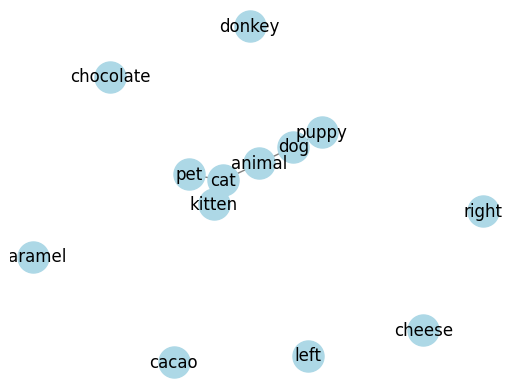

In [48]:
# Construct an empty graph
graph = nx.Graph()

# Add nodes to the graph
graph.add_nodes_from(wordList)

# Add edges between related words
graph.add_edges_from([('cat', 'kitten'), ('dog', 'puppy'), ('cat', 'animal'), ('dog', 'animal'), ('cat', 'pet')])

# Print the graph information
print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())

# Access neighbors of a word
word = 'cat'
neighbors = graph.neighbors(word)
print("Neighbors of", word + ":", list(neighbors))

# Create the layout for the graph
layout = nx.spring_layout(graph)

# Draw the nodes
nx.draw_networkx_nodes(graph, pos=layout, node_color='lightblue', node_size=500)

# Draw the edges
nx.draw_networkx_edges(graph, pos=layout, edge_color='gray')

# Add labels to the nodes
nx.draw_networkx_labels(graph, pos=layout, font_color='black')

# Set plot properties
plt.axis('off')

plt.show()

In [34]:
updates

[array([[-0.00338463, -0.08622685,  0.16280252, ..., -0.24678802,
          0.1382305 , -0.00531627],
        [-0.03198242, -0.03887939,  0.1680603 , ..., -0.07519531,
          0.11132812, -0.11047363],
        [-0.02303205,  0.03158133,  0.03653172, ..., -0.20851935,
          0.12104144, -0.07918149],
        ...,
        [ 0.04876709, -0.05186462,  0.02301025, ...,  0.03039551,
         -0.06762695,  0.05160522],
        [-0.06775391,  0.00456909, -0.04078857, ..., -0.0266507 ,
          0.00619671,  0.00296964],
        [-0.05705015, -0.03352196,  0.00141513, ...,  0.02340009,
          0.07202345, -0.02153556]]),
 array([[-0.00169231, -0.04311343,  0.08140126, ..., -0.12339401,
          0.06911525, -0.00265814],
        [-0.01599121, -0.0194397 ,  0.08403015, ..., -0.03759766,
          0.05566406, -0.05523682],
        [-0.01151603,  0.01579067,  0.01826586, ..., -0.10425967,
          0.06052072, -0.03959074],
        ...,
        [ 0.02438354, -0.02593231,  0.01150513, ...,  

In [35]:
# retrofitted_toy_matrix = convert_dict_to_matrix(retrofitted_toy_vecs)
retrofitted_similarity_matrix = generate_cosine_similarity_matrix(retrofitted_toy_vecs)
print_vec_similarities(toy_corpus, retrofitted_similarity_matrix)

Similarities with "cat":
  - "kitten": 0.5575
  - "dog": 0.9034
  - "donkey": 0.7162
  - "caramel": 0.8455
  - "cheese": 0.6870
  - "chocolate": 0.7851
  - "cacao": 0.6675
  - "right": 0.7251
  - "left": 0.6200

Similarities with "kitten":
  - "cat": 0.5575
  - "dog": 0.6424
  - "donkey": 0.5728
  - "caramel": 0.5358
  - "cheese": 0.3870
  - "chocolate": 0.5269
  - "cacao": 0.4280
  - "right": 0.4215
  - "left": 0.4057

Similarities with "dog":
  - "cat": 0.9034
  - "kitten": 0.6424
  - "donkey": 0.7576
  - "caramel": 0.8149
  - "cheese": 0.6797
  - "chocolate": 0.7217
  - "cacao": 0.6009
  - "right": 0.7366
  - "left": 0.5588

Similarities with "donkey":
  - "cat": 0.7162
  - "kitten": 0.5728
  - "dog": 0.7576
  - "caramel": 0.5718
  - "cheese": 0.5547
  - "chocolate": 0.6405
  - "cacao": 0.5916
  - "right": 0.5420
  - "left": 0.4083

Similarities with "caramel":
  - "cat": 0.8455
  - "kitten": 0.5358
  - "dog": 0.8149
  - "donkey": 0.5718
  - "cheese": 0.7350
  - "chocolate": 0.8500


In [24]:
similarity_matrix[0,1]

0.7464983463287354

In [36]:
def print_vec_difference(wordList, similarity_matrix1, similarity_matrix2):
    for i, word in enumerate(wordList):
        print(f"\nSimilarities with \"{word}\":")
        for j, neighbor in enumerate(wordList):
            similarity1 = similarity_matrix1[i, j]
            similarity2 = similarity_matrix2[i, j]
            difference = similarity2 - similarity1  # Calculate the difference
            print(f"  - \"{neighbor}\": {similarity1:.4f} -> {similarity2:.4f} (Difference: {difference:.4f})")

print_vec_difference(toy_corpus, similarity_matrix, retrofitted_similarity_matrix)


Similarities with "cat":
  - "cat": 1.0000 -> 1.0000 (Difference: 0.0000)
  - "kitten": 0.7465 -> 0.1934 (Difference: -0.5531)
  - "dog": 0.7609 -> 0.5609 (Difference: -0.2000)
  - "donkey": 0.4010 -> 0.3359 (Difference: -0.0652)
  - "caramel": 0.1662 -> 0.4905 (Difference: 0.3243)
  - "cheese": 0.1403 -> 0.2844 (Difference: 0.1441)
  - "chocolate": 0.2410 -> 0.4024 (Difference: 0.1615)
  - "cacao": 0.0969 -> 0.2809 (Difference: 0.1840)
  - "right": 0.0848 -> 0.3539 (Difference: 0.2690)
  - "left": 0.1096 -> 0.3224 (Difference: 0.2128)

Similarities with "kitten":
  - "cat": 0.7465 -> 0.1934 (Difference: -0.5531)
  - "kitten": 1.0000 -> 1.0000 (Difference: 0.0000)
  - "dog": 0.6660 -> 0.3080 (Difference: -0.3580)
  - "donkey": 0.4177 -> 0.2355 (Difference: -0.1822)
  - "caramel": 0.2063 -> 0.2053 (Difference: -0.0009)
  - "cheese": 0.0729 -> 0.0759 (Difference: 0.0030)
  - "chocolate": 0.2207 -> 0.2042 (Difference: -0.0165)
  - "cacao": 0.0684 -> 0.1240 (Difference: 0.0556)
  - "right

In [26]:
def print_similarity_difference(similarity_matrix, retrofitted_similarity_matrix):
    difference = np.abs(similarity_matrix - retrofitted_similarity_matrix)
    print("Similarity Difference Matrix:")
    print(difference)

print_similarity_difference(similarity_matrix, retrofitted_similarity_matrix)

Similarity Difference Matrix:
[[2.22044605e-16 5.53118424e-01 2.00049708e-01 6.51759722e-02
  3.24295518e-01 1.44140853e-01 1.61451777e-01 1.84015317e-01
  2.69016803e-01 2.12769555e-01]
 [5.53118424e-01 5.96046448e-08 3.58011316e-01 1.82194134e-01
  9.39687112e-04 3.03516253e-03 1.64577970e-02 5.55693512e-02
  7.57305401e-02 7.96499373e-02]
 [2.00049708e-01 3.58011316e-01 1.19209290e-07 7.86625771e-02
  3.01802265e-01 1.28789430e-01 3.12336325e-04 1.17003134e-01
  2.72029846e-01 1.49775447e-01]
 [6.51759722e-02 1.82194134e-01 7.86625771e-02 0.00000000e+00
  3.93168452e-02 5.66114522e-09 4.65277457e-02 8.93911934e-02
  8.97796765e-02 7.77400103e-04]
 [3.24295518e-01 9.39687112e-04 3.01802265e-01 3.93168452e-02
  1.11022302e-16 1.43969249e-01 1.99748842e-01 3.56024227e-02
  1.55936488e-01 2.61765471e-03]
 [1.44140853e-01 3.03516253e-03 1.28789430e-01 5.66114522e-09
  1.43969249e-01 0.00000000e+00 2.03076132e-01 4.36872380e-02
  2.22093413e-02 5.34325862e-02]
 [1.61451777e-01 1.64577970e

In [27]:
def evaluate_similarity_score(target_words, similarity_matrix):
    total_score = 0
    num_scores = 0

    for i, word in enumerate(target_words):
        synonyms = get_wordnet_lexicon(word, "synonyms")  
        if not synonyms:
            continue

        word_scores = []
        for syn in synonyms:
            if syn in target_words:
                syn_index = target_words.index(syn)
                word_scores.append(similarity_matrix[i, syn_index])

        if word_scores:
            avg_score = sum(word_scores) / len(word_scores)
            total_score += avg_score
            num_scores += 1

    if num_scores > 0:
        return total_score / num_scores
    else:
        return 0.0

In [28]:
# Find best values for hyperparameters
alpha_values = [0.5, 1, 2]
beta_values = [0.5, 1, 2]
nb_iter_values = [5, 10, 15]

best_similarity_score = -1  # Variable to store the best similarity score
best_params = {}  # Dictionary to store the best hyperparameter values

for alpha in alpha_values:
    for beta in beta_values:
        for nb_iter in nb_iter_values:
            retrofitted_toy_vecs, _ = retrofitting_wordVecs(wordVecMat, neighbors_matrix, alpha, beta, nb_iter)
            retrofitted_similarity_matrix = generate_cosine_similarity_matrix(retrofitted_toy_vecs)
            similarity_score = evaluate_similarity_score(toy_corpus, retrofitted_similarity_matrix)

            if similarity_score > best_similarity_score:
                best_similarity_score = similarity_score
                best_params = {'alpha': alpha, 'beta': beta, 'nb_iter': nb_iter}

print("Best hyperparameters:", best_params)
print("Best similarity score:", best_similarity_score)

Best hyperparameters: {'alpha': 0.5, 'beta': 0.5, 'nb_iter': 5}
Best similarity score: 0.0


In [29]:
new_retrofitted_toy_vecs, new_updates = retrofitting_wordVecs(wordVecMat, neighbors_matrix, alpha=0.5, beta=0.5, nb_iter=5)
new_retrofitted_similarity_matrix = generate_cosine_similarity_matrix(new_retrofitted_toy_vecs)
print_vec_similarities(toy_corpus, new_retrofitted_similarity_matrix)

Similarities with "cat":
  - "kitten": 0.6078
  - "dog": 0.9133
  - "donkey": 0.7376
  - "caramel": 0.8506
  - "cheese": 0.6928
  - "chocolate": 0.7903
  - "cacao": 0.6767
  - "right": 0.7246
  - "left": 0.6207

Similarities with "kitten":
  - "cat": 0.6078
  - "dog": 0.6810
  - "donkey": 0.5990
  - "caramel": 0.5609
  - "cheese": 0.4040
  - "chocolate": 0.5433
  - "cacao": 0.4460
  - "right": 0.4359
  - "left": 0.4172

Similarities with "dog":
  - "cat": 0.9133
  - "kitten": 0.6810
  - "donkey": 0.7751
  - "caramel": 0.8145
  - "cheese": 0.6813
  - "chocolate": 0.7256
  - "cacao": 0.6074
  - "right": 0.7337
  - "left": 0.5639

Similarities with "donkey":
  - "cat": 0.7376
  - "kitten": 0.5990
  - "dog": 0.7751
  - "caramel": 0.5807
  - "cheese": 0.5581
  - "chocolate": 0.6439
  - "cacao": 0.5936
  - "right": 0.5463
  - "left": 0.4164

Similarities with "caramel":
  - "cat": 0.8506
  - "kitten": 0.5609
  - "dog": 0.8145
  - "donkey": 0.5807
  - "cheese": 0.7526
  - "chocolate": 0.8641


In [30]:
# Difference between original and after tuning hyperparam
print_vec_difference(toy_corpus, similarity_matrix, new_retrofitted_similarity_matrix) 


Similarities with "cat":
  - "cat": 1.0000 -> 1.0000 (Difference: 0.0000)
  - "kitten": 0.7465 -> 0.2324 (Difference: -0.5141)
  - "dog": 0.7609 -> 0.5787 (Difference: -0.1823)
  - "donkey": 0.4010 -> 0.3563 (Difference: -0.0447)
  - "caramel": 0.1662 -> 0.4988 (Difference: 0.3326)
  - "cheese": 0.1403 -> 0.2878 (Difference: 0.1475)
  - "chocolate": 0.2410 -> 0.4077 (Difference: 0.1667)
  - "cacao": 0.0969 -> 0.2888 (Difference: 0.1919)
  - "right": 0.0848 -> 0.3551 (Difference: 0.2703)
  - "left": 0.1096 -> 0.3214 (Difference: 0.2118)

Similarities with "kitten":
  - "cat": 0.7465 -> 0.2324 (Difference: -0.5141)
  - "kitten": 1.0000 -> 1.0000 (Difference: 0.0000)
  - "dog": 0.6660 -> 0.3370 (Difference: -0.3290)
  - "donkey": 0.4177 -> 0.2469 (Difference: -0.1709)
  - "caramel": 0.2063 -> 0.2161 (Difference: 0.0099)
  - "cheese": 0.0729 -> 0.0774 (Difference: 0.0045)
  - "chocolate": 0.2207 -> 0.2091 (Difference: -0.0116)
  - "cacao": 0.0684 -> 0.1293 (Difference: 0.0609)
  - "right"

In [31]:
# Difference between retrofitted embeddings and after tuning hyperaparams
print_vec_difference(toy_corpus, retrofitted_similarity_matrix, new_retrofitted_similarity_matrix)


Similarities with "cat":
  - "cat": 1.0000 -> 1.0000 (Difference: 0.0000)
  - "kitten": 0.1922 -> 0.2324 (Difference: 0.0402)
  - "dog": 0.5604 -> 0.5787 (Difference: 0.0183)
  - "donkey": 0.3352 -> 0.3563 (Difference: 0.0211)
  - "caramel": 0.4902 -> 0.4988 (Difference: 0.0086)
  - "cheese": 0.2843 -> 0.2878 (Difference: 0.0035)
  - "chocolate": 0.4022 -> 0.4077 (Difference: 0.0055)
  - "cacao": 0.2807 -> 0.2888 (Difference: 0.0082)
  - "right": 0.3538 -> 0.3551 (Difference: 0.0013)
  - "left": 0.3224 -> 0.3214 (Difference: -0.0010)

Similarities with "kitten":
  - "cat": 0.1922 -> 0.2324 (Difference: 0.0402)
  - "kitten": 1.0000 -> 1.0000 (Difference: 0.0000)
  - "dog": 0.3071 -> 0.3370 (Difference: 0.0299)
  - "donkey": 0.2352 -> 0.2469 (Difference: 0.0117)
  - "caramel": 0.2050 -> 0.2161 (Difference: 0.0112)
  - "cheese": 0.0759 -> 0.0774 (Difference: 0.0015)
  - "chocolate": 0.2041 -> 0.2091 (Difference: 0.0050)
  - "cacao": 0.1238 -> 0.1293 (Difference: 0.0055)
  - "right": 0.11